In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from lib import DihedralAdherence
from lib import PDBMineQuery, MultiWindowQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from dotenv import load_dotenv
import torch
from torch import nn
import torch.nn.functional as F
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import pickle
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from lib.constants import AMINO_ACID_MAP, AMINO_ACID_MAP_INV
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'

In [240]:
pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir()]
winsizes = [4,5,6,7]
nbins = 90
outdir = Path(f'ml_samples/grid-{nbins}')
outdir.mkdir(exist_ok=True, parents=True)

for id in pdb_codes:
    try:
        da = MultiWindowQuery(id, winsizes, PDBMINE_URL, PROJECT_DIR)
        # da.compute_structure()
        da.load_results()
    except FileNotFoundError as e:
        print(e)
        continue
    if da.af_phi_psi is None:
        continue

    seqs = pd.merge(
        da.xray_phi_psi[['seq_ctxt', 'res', 'phi', 'psi']], 
        da.af_phi_psi[['seq_ctxt', 'phi', 'psi']], 
        on='seq_ctxt', suffixes=('', '_af')
    ).rename(columns={'seq_ctxt': 'seq'})
    if seqs.shape[0] == 0:
        print('No sequences for', id)
        continue

    print(seqs.shape, seqs.seq.nunique())
    X = []
    x_res = []
    af_phi_psi = []
    af_confs = []
    y = []
    for i,row in tqdm(seqs.iterrows()):
        grids = []
        if np.isnan(row.phi) or np.isnan(row.psi) or np.isnan(row.phi_af) or np.isnan(row.psi_af):
            print('NaNs for', row.seq)
            continue
        af_conf = da.af_phi_psi.loc[da.af_phi_psi.seq_ctxt == row.seq, 'conf'].values[0]
        for q in da.queries:
            inner_seq = q.get_subseq(row.seq)
            matches = q.results[q.results.seq == inner_seq]
            phi = matches.phi.values
            psi = matches.psi.values
            keep = (phi <= 180) & (psi <= 180)
            phi = phi[keep]
            psi = psi[keep]
            if phi.shape[0] == 0:
                grids.append(torch.zeros(nbins, nbins))
                continue
            
            # Compute grid
            grids.append(torch.tensor(np.histogram2d(
                phi, psi, bins=nbins, range=[[-180, 180], [-180, 180]], density=True
            )[0]))

        grids = torch.stack(grids)
        X.append(grids)
        x_res.append(AMINO_ACID_MAP[row.res])
        af_phi_psi.append(torch.tensor([row.phi_af, row.psi_af]))
        af_confs.append(af_conf)
        y.append(torch.tensor([row.phi, row.psi]))
    X = torch.stack(X)
    x_res = F.one_hot(torch.tensor(x_res).to(torch.int64), num_classes=20)
    af_phi_psi = torch.stack(af_phi_psi)
    af_conf = torch.tensor(af_confs)
    y = torch.stack(y)
    print(X.shape, y.shape, x_res.shape, af_phi_psi.shape, af_conf.shape)
    torch.save((X, x_res, af_phi_psi, af_conf, y), outdir / f'{id}.pt')

Results already exist
Structure exists: 'pdb/pdb7mh0.ent' 
UniProt ID: P17812
(550, 6) 550


550it [00:26, 20.57it/s]


torch.Size([550, 4, 90, 90]) torch.Size([550, 2]) torch.Size([550, 20]) torch.Size([550, 2]) torch.Size([550])


In [70]:
class ProteinDatasetKDE(Dataset):
    def __init__(self, id, path):
        self.id = id
        self.path = path

        self.X, self.xres, self.af, self.conf, self.y = torch.load(self.path / f'{id}.pt')
        self.X, self.xres, self.af, self.conf, self.y = self.X.float(), self.xres.float(), self.af.float(), self.conf.float(), self.y.float()
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.xres[i], self.af[i], self.conf[i], self.y[i]

In [344]:
path = Path('ml_samples/grid-90')
train, test = torch.load('ml_runs/split.pt')
train_dataset = ConcatDataset([ProteinDatasetKDE(id, path) for id in train])
test_dataset = ConcatDataset([ProteinDatasetKDE(id, path) for id in test])

trainloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

len(train_dataset), len(test_dataset), len(train_dataset) + len(test_dataset)

(68523, 38139, 106662)

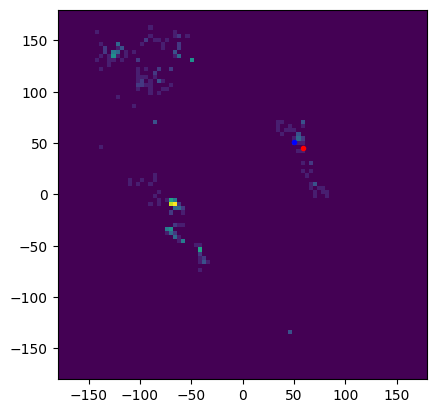

In [330]:
X, x_res, af, conf, y = next(iter(trainloader))
def plot(x, y, af, i):
    x = x[i].detach().numpy()[0].T[::-1]
    y = y[i].detach().numpy()
    af = af[i].detach().numpy()
    plt.imshow(x, extent=[-180, 180, -180, 180])
    plt.plot(y[0], y[1], 'r.')
    plt.plot(af[0], af[1], 'b.')
plot(X, y, af, 9)

In [340]:
def save_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    torch.save(model.state_dict(), path)
def load_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    model.load_state_dict(torch.load(path))
    return model

In [356]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 16, 15, stride=2, padding=7)
        # self.bn1 = nn.BatchNorm2d(16, affine=True, momentum=0.7)
        self.ln1 = nn.LayerNorm((16,45,45), elementwise_affine=True)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        # self.bn2 = nn.BatchNorm2d(32, affine=True, momentum=0.7)
        self.ln2 = nn.LayerNorm((32,23,23), elementwise_affine=True)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        # self.bn3 = nn.BatchNorm2d(64, affine=True, momentum=0.7)
        self.ln3 = nn.LayerNorm((64,12,12), elementwise_affine=True)
        self.l1 = nn.Linear(64*12*12+20+2, 4)
        self.l2 = nn.Linear(4, 2)
        # self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        # self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        # self.l2 = nn.Linear(32, 2)
    def forward(self, X, xres, af, conf):
        # x = torch.cat([X.flatten(1), xres, af], dim=1)
        # x = F.relu(self.l1(x))
        # x = self.l2(x)
        x = self.conv1(X)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.ln3(x)
        x = F.relu(x)
        x = x.flatten(1)
        x = torch.hstack([x, xres, af])
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x
    
class AngleMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        def diff(x1, x2):
            d = torch.abs(x1 - x2)
            d = torch.minimum(d, 360-d)
            return d
        phi_diff = diff(x[:,0], y[:,0]).unsqueeze(1)
        psi_diff = diff(x[:,1], y[:,1]).unsqueeze(1)
        return torch.mean(torch.hstack([phi_diff, psi_diff])**2)

device = 'cuda:0'
model = nn.DataParallel(Net()).to(device)
criterion = AngleMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
sum([p.numel() for p in model.parameters()])

191606

In [357]:
X,xres,af,conf,y = next(iter(trainloader))
print(X.shape, xres.shape, af.shape, y.shape)
model(X.to(device),xres.to(device),af.to(device),conf.to(device)).shape

torch.Size([512, 4, 90, 90]) torch.Size([512, 20]) torch.Size([512, 2]) torch.Size([512, 2])


torch.Size([512, 2])

In [308]:
# 771 - no af
# 448 - 8 hidden neurons
# 389 - layer norm affine=True
#     - 4 hidden neurons

In [358]:
train_losses = []
test_losses = []
lowest_test_loss = float('inf')
writer = SummaryWriter('tensorboard')
for epoch in (pbar := tqdm(range(500))):
    losses = []
    model.train()
    for X,xres,af,conf,y in trainloader:
        X,xres,af,conf,y = X.to(device), xres.to(device), af.to(device), conf.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X, xres, af, conf)
        if logits.isnan().sum() > 0:
            raise ValueError('nan')
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    model.eval()
    for X,xres,af,conf,y in testloader:
        with torch.no_grad():
            X,xres,af,conf,y = X.to(device), xres.to(device), af.to(device), conf.to(device), y.to(device)
            logits = model(X, xres, af, conf)
            loss = criterion(logits, y)
            losses.append(loss.item())
    test_losses.append(sum(losses) / len(losses))
    if test_losses[-1] < lowest_test_loss:
        lowest_test_loss = test_losses[-1]
        save_model(model, 'ml_runs/best_model.pt')
    writer.add_scalars('Loss', {
        'train': train_losses[-1],
        'test': test_losses[-1]
    }, epoch)
    writer.flush()

    pbar.set_postfix({'train_loss': train_losses[-1], 'test_loss': test_losses[-1]})
writer.close()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [39:17<00:00,  4.71s/it, train_loss=66.6, test_loss=531]     


In [355]:
model = nn.DataParallel(Net().to(device))
load_model(model, 'ml_runs/best_model.pt')
model.eval()
preds = []
true = []
loss = []

model.eval()
for X,xres,af,conf,y in tqdm(testloader):
    with torch.no_grad():
        X,xres,af,conf,y = X.to(device), xres.to(device), af.to(device), conf.to(device), y.to(device)
        logits = model(X, xres, af, conf)
        lossi = criterion(logits, y)
        loss.append(lossi.item())
        preds.append(logits.cpu().numpy())
        true.append(y.cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)
loss = np.mean(loss)
loss

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:01<00:00, 43.65it/s]


389.80243952433267